In [1]:
from PIL import Image
from tqdm import tqdm
from glob import glob

import random
import numpy as np
import json
import matplotlib.pyplot as plt

import os
import cv2
import shutil

In [2]:
# Google Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/Training'):
    os.mkdir('data/Training')

In [4]:
# Dataset unzip
!tar -xvf /content/drive/MyDrive/AI_Factory/data/Train_Dataset.tar 
!tar -xvf /content/drive/MyDrive/AI_Factory/data/Valid_Dataset.tar 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
content/s_data/Validation/cow_label/livestock_cow_bbox_010486.json
content/s_data/Validation/cow_label/livestock_cow_bbox_009198.json
content/s_data/Validation/cow_label/livestock_cow_bbox_013289.json
content/s_data/Validation/cow_label/livestock_cow_bbox_011089.json
content/s_data/Validation/cow_label/livestock_cow_bbox_002452.json
content/s_data/Validation/cow_label/livestock_cow_bbox_003887.json
content/s_data/Validation/cow_label/livestock_cow_bbox_012032.json
content/s_data/Validation/cow_label/livestock_cow_bbox_013598.json
content/s_data/Validation/cow_label/livestock_cow_bbox_009150.json
content/s_data/Validation/cow_label/livestock_cow_bbox_000011.json
content/s_data/Validation/cow_label/livestock_cow_bbox_010693.json
content/s_data/Validation/cow_label/livestock_cow_bbox_000646.json
content/s_data/Validation/cow_label/livestock_cow_bbox_003115.json
content/s_data/Validation/cow_label/livestock_cow_bbox_000984.json
content/s_data/Validation/

In [8]:
# Data 불러오기
train_pig_image = glob('/content/content/s_data/Training/pig_image/*.jpg')
train_cow_image = glob('/content/content/s_data/Training/cow_image/*.jpg')
train_pig_label = glob('/content/content/s_data/Training/pig_label/*.json')
train_cow_label = glob('/content/content/s_data/Training/cow_label/*.json')

valid_pig_image = glob('/content/content/s_data/Validation/pig_image/*.jpg')
valid_cow_image = glob('/content/content/s_data/Validation/cow_image/*.jpg')
valid_pig_label = glob('/content/content/s_data/Validation/pig_label/*.json')
valid_cow_label = glob('/content/content/s_data/Validation/cow_label/*.json')

In [9]:
print("Train - 소 Data의 개수:", len(train_cow_image))
print("Train - 돼지 Data의 개수:", len(train_pig_image))
print("Valid - 소 Data의 개수:", len(valid_cow_image))
print("Valid - 돼지 Data의 개수:", len(valid_pig_image))

Train - 소 Data의 개수: 9722
Train - 돼지 Data의 개수: 3442
Valid - 소 Data의 개수: 2430
Valid - 돼지 Data의 개수: 861


### Error Analysis

             Train      Valid
      PIG     3442      861
      COW     9722      2430


---

- Cow의 Data 양이 더 많음 - COW : PIG = 3:1
- Pretrain Model의 사전학습 Data의 Cow Data를 포함 (YOLOv5 Pretrained from COCO)
- 위의 두 가지 이점에도 불구하고,

                     Label    Precision   Recall    mAP 0.5   mAP 0.5:0.95
            pig       3291      0.984      0.991      0.993       0.928
            cow       3291      0.929      0.911      0.974       0.889

위의 수치에서 볼 수 있다시피, **Cow를 Detection하는데 있어서 모델이 어려움**을 겪는다.

### Pig, Cow Dataset에서 Box 개수 시각화

In [10]:
def ratio_check(w, h):
    if w / (w+h) >= 0.6: # 1.5 : 1 보다 더 큰 ratio일 경우
        return 'horizontally'
    elif h / (w+h) >= 0.6:
        return 'vertically'
    else:
        return 'square'

def area_check(w, h):
    if w * h >= 100000:
        return 'very_large'
    elif w*h >= 50000:
        return 'large'
    elif w*h >= 10000:
        return 'medium'
    elif w*h >= 1000:
        return 'small'
    elif w*h >= 100:
        return 'very_small'
    elif w * h < 100:
        return 'out'

In [11]:
# Train Pig data에 대한 box의 개수 및 size
train_pig_box_count = []
train_pig_box_size = {'horizontally':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      },
                      'vertically':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0      
                      },
                      'square':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      }}

for label in tqdm(train_pig_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    train_pig_box_count.append(box_count)

    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1

        ratio = ratio_check(w,h)
        area = area_check(w, h)

        train_pig_box_size[ratio][area] += 1

100%|██████████| 3442/3442 [00:00<00:00, 4356.44it/s]


In [12]:
# Train Cow data에 대한 box의 개수 및 size

train_cow_box_count = []
train_cow_box_size = {'horizontally':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      },
                      'vertically':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0      
                      },
                      'square':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      }}

for label in tqdm(train_cow_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    train_cow_box_count.append(box_count)

    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1

        ratio = ratio_check(w,h)
        area = area_check(w, h)

        train_cow_box_size[ratio][area] += 1

100%|██████████| 9722/9722 [00:02<00:00, 3601.80it/s]


In [15]:
# Test Pig data에 대한 box의 개수 및 size

valid_pig_box_count = []
valid_pig_box_size = {'horizontally':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      },
                      'vertically':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0      
                      },
                      'square':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      }}

for label in tqdm(valid_pig_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    valid_pig_box_count.append(box_count)

    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1

        ratio = ratio_check(w,h)
        area = area_check(w, h)

        valid_pig_box_size[ratio][area] += 1

100%|██████████| 861/861 [00:00<00:00, 12950.95it/s]


In [16]:
# Test Cow data에 대한 box의 개수 및 size

valid_cow_box_count = []
valid_cow_box_size = {'horizontally':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      },
                      'vertically':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0      
                      },
                      'square':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      }}

for label in tqdm(valid_cow_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    valid_cow_box_count.append(box_count)

    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1

        ratio = ratio_check(w,h)
        area = area_check(w, h)

        valid_cow_box_size[ratio][area] += 1

100%|██████████| 2430/2430 [00:00<00:00, 5595.11it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

(array([424., 490., 583., 413., 261., 112.,  76.,  54.,  16.,   1.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

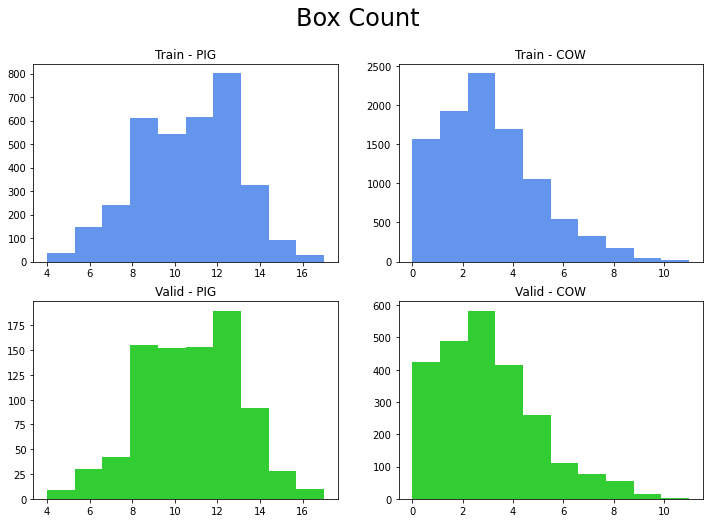

In [18]:
# Box의 개수 시각화
plt.figure(figsize = (12, 8))
plt.suptitle('Box Count', fontsize=24)

plt.subplot(221)
plt.subplot(221).set_title('Train - PIG')
plt.hist(train_pig_box_count, color='cornflowerblue')

plt.subplot(222)
plt.subplot(222).set_title('Train - COW')
plt.hist(train_cow_box_count, color='cornflowerblue')

plt.subplot(223)
plt.subplot(223).set_title('Valid - PIG')
plt.hist(valid_pig_box_count, color='limegreen')

plt.subplot(224)
plt.subplot(224).set_title('Valid - COW')
plt.hist(valid_cow_box_count, color='limegreen')

### Cow Image에 대한 Box Plotting

In [20]:
train_cow_label.sort()
train_cow_image.sort()
valid_cow_label.sort()
valid_cow_image.sort()

In [21]:
# Train Example
with open(train_cow_label[7], 'r') as data:
    label_data = json.load(data)
box_info = label_data['label_info']['annotations']

image = Image.open(train_cow_image[7])
image = np.array(image)
for box in box_info:
    box = box['bbox']
    img = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0,0,255), 3)
pil_image = Image.fromarray(image)
pil_image

Output hidden; open in https://colab.research.google.com to view.

In [22]:
# Valid Example
with open(valid_cow_label[0], 'r') as data:
    label_data = json.load(data)
box_info = label_data['label_info']['annotations']

image = Image.open(valid_cow_image[0])
image = np.array(image)
for box in box_info:
    box = box['bbox']
    img = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0,0,255), 3)
pil_image = Image.fromarray(image)
pil_image

Output hidden; open in https://colab.research.google.com to view.

### Conclusion

- 전반적으로 Cow Dataset에서의 Bounding Box의 개수가 적다.
- Image를 Plotting한 결과, Cow Dataset에서의 Labeling이 제대로 되어있지 않다.
    -  FP의 증가로 이어질 수 있다. (Labeling이 되어있지 않지만, Cow라고 예측)
-  이러한 결과로부터, Silver Dataset을 만들어 재학습시키도록 한다.
    - 학습된 Model로 Cow Image에 대하여 Bounding Box를 예측한다.
    - 예측된 결과를 추가학습데이터로 활용한다.    